In [1]:
# Importing modules
import torch as to
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch.utils.data as to_data
from torch.utils.tensorboard import SummaryWriter as sumwriter
import os as os

In [2]:
# Specify hardware for ML training (GPU default)
device = "cuda" if to.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Quickly generate list of strings for frequency numbers and ratios
def freq_name(no_freq, include_freq=True, include_ratio=True):
    """
    Creates an ordered list of string from inputted parameters:

    no_freq = (int) number of desired frequencies
    include_freq = (bool) include the individual frequencies or not (default True)
    include_ratio = (bool) include the non-trivial ratios between frequencies or not (default True)
    """
    names = []
    if include_freq:
        for i in range(no_freq):
            names.append('f'+str(i+1))
    if include_ratio:
        for i in range(no_freq):
            for j in range(i):
                names.append('f'+str(i+1)+'/f'+str(j+1))
    return names

In [4]:
def activation(activ_name):
    if activ_name=='relu':
        return to.nn.ReLU()
    elif activ_name=='lrelu':
        return to.nn.LeakyReLU()
    elif activ_name=='prelu':
        return to.nn.PReLU()
    elif activ_name=='relu6':
        return to.nn.ReLU6()
    elif activ_name=='sigmoid':
        return to.nn.Sigmoid()
    elif activ_name=='tanh':
        return to.nn.Tanh()
    elif activ_name=='silu':
        return to.nn.SiLU()
    elif activ_name=='selu':
        return to.nn.SELU()
    elif activ_name=='celu':
        return to.nn.CELU()
    elif activ_name=='gelu':
        return to.nn.GELU()
    else:
        return to.nn.ReLU()

In [5]:
class AE_data(to_data.Dataset):
    def __init__(self, scaled_dataframe, X_names, Y_names):
        self.len = len(scaled_dataframe)
        self.X = to.from_numpy(scaled_dataframe[X_names].to_numpy().astype('float32')).to(device)
        self.Y = to.from_numpy(scaled_dataframe[Y_names].to_numpy().astype('float32')).to(device)

    def __len__(self):
        return self.len
  
    def __getitem__(self, idx):
        X_idx = self.X[idx,:]
        Y_idx = self.Y[idx,:]
        return X_idx, Y_idx

In [6]:
class AE_Network(to.nn.Module):
    def __init__(self, num_X, num_Z, num_Y, he_nodes, hd_nodes, hde_nodes, hactiv_type):
        super(AE_Network, self).__init__()

        self.esec = []
        self.esec.append(to.nn.Linear(num_X, he_nodes[0]))
        self.esec.append(activation(hactiv_type))

        for i in range(len(he_nodes)-1):
            self.esec.append(to.nn.Linear(he_nodes[i], he_nodes[i+1]))
            self.esec.append(activation(hactiv_type))

        self.esec.append(to.nn.Linear(he_nodes[-1], num_Z))

        self.esec = to.nn.Sequential(*self.esec).to(device)
        for i in self.esec[::2]:
            to.nn.init.xavier_uniform_(i.weight)
            to.nn.init.zeros_(i.bias)


        self.dsec = []
        self.dsec.append(to.nn.Linear(num_Z, hd_nodes[0]))
        self.dsec.append(activation(hactiv_type))

        for i in range(len(hd_nodes)-1):
            self.dsec.append(to.nn.Linear(hd_nodes[i], hd_nodes[i+1]))
            self.dsec.append(activation(hactiv_type))

        self.dsec.append(to.nn.Linear(hd_nodes[-1], num_X))
        
        self.dsec = to.nn.Sequential(*self.dsec).to(device)
        for i in self.dsec[::2]:
            to.nn.init.xavier_uniform_(i.weight)
            to.nn.init.zeros_(i.bias)


        self.desec = []
        self.desec.append(to.nn.Linear(num_Z, hde_nodes[0]))
        self.desec.append(activation(hactiv_type))

        for i in range(len(hde_nodes)-1):
            self.desec.append(to.nn.Linear(hde_nodes[i], hde_nodes[i+1]))
            self.desec.append(activation(hactiv_type))

        self.desec.append(to.nn.Linear(hde_nodes[-1], num_Y))
        
        self.desec = to.nn.Sequential(*self.desec).to(device)
        for i in self.desec[::2]:
            to.nn.init.xavier_uniform_(i.weight)
            to.nn.init.zeros_(i.bias)

    def encode(self, X):
        Z = self.esec(X)
        return Z
    
    def decode(self, Z):
        Xp = self.dsec(Z)
        return Xp

    def dualdecode(self, Z):
        Yp = self.desec(Z)
        return Yp

    def forward(self, X):
        Z = self.encode(X)
        Xp = self.decode(Z)
        Yp = self.dualdecode(Z)
        return Xp, Yp, Z

In [7]:
def train_epoch(
    network,
    train_dataloader, loss_weight,
    loss_function, optimizer,
    tb_writer, epoch_ind
    ):

    loss_list = []

    for i, data in enumerate(train_dataloader):
        X, Y = data

        if epoch_ind==0 and i==0:
            tb_writer.add_graph(network, X, verbose=False)

        optimizer.zero_grad()
        Xp, Yp, Z = network(X)
        loss = loss_function(Xp, X) + loss_weight*loss_function(Yp, Y)
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()
    
    mean_loss = to.mean(to.tensor(loss_list, device=device)).item()

    return mean_loss

def valid_epoch(
    network,
    valid_dataloader, loss_weight,
    loss_function
    ):

    loss_list = []

    for i, data in enumerate(valid_dataloader):
        X, Y = data
        Xp, Yp, Z = network(X)
        loss = loss_function(Xp, X) + loss_weight*loss_function(Yp, Y) 
        loss_list.append(loss.item())
        
    mean_loss = to.mean(to.tensor(loss_list, device=device)).item()

    return mean_loss

In [8]:
def train_AE(
    network,
    train_dataloader, valid_dataloader, loss_weight,
    loss_function, optimizer_type,
    epochs, learn_rate
    ):

    if optimizer_type=='adam':
        optimizer = to.optim.Adam(network.parameters(), lr=learn_rate)
    else:
        optimizer = to.optim.SGD(network.parameters(), lr=learn_rate)
    
    tb_writer = sumwriter('Current_ML_Results/Tensorboard')
    
    for i in range(epochs):
        network.train(True)
        mloss = train_epoch(network, train_dataloader, loss_weight, loss_function, optimizer, tb_writer, i)

        network.eval()
        with to.no_grad():
            vmloss = valid_epoch(network, valid_dataloader, loss_weight, loss_function)
        
        print('-'*50)
        print('Epoch {} / {}'.format(i+1,epochs))
        print('-'*15)
        print('Average Train Loss : {}'.format(mloss))
        print('Average Validation Loss : {}'.format(vmloss))

        tb_writer.add_scalars("Batch Mean Loss",
                            {
                                'Train' : mloss,
                                'Validation' : vmloss
                            }, i+1)
                            
    tb_writer.flush()
    tb_writer.close()

In [9]:
# Prepare Data
data = pd.read_csv('Data Workspace\FM_TV_Data.csv')
num_freq = 4

X_names = freq_name(num_freq,1,0)
Y_names = ['nu', 'a/b']

train_split = int(0.8*len(data))
valid_split = len(data)- train_split

scaled_data = data[X_names+Y_names].copy()

# scaled_data['psi'] = np.log(scaled_data['psi'])
# scaled_data['E'] = scaled_data['E']/1e11
# scaled_data['rho'] = scaled_data['rho']/10000
# scaled_data['t'] = scaled_data['t']*100
scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])

scaled_data = AE_data(scaled_data, X_names, Y_names)
train_set, valid_set = to_data.random_split(scaled_data, [train_split, valid_split])

In [10]:
# Train Model
# Parameters
num_X = len(X_names)
num_Y = len(Y_names)
num_Z = 4
he_nodes = [10,10,20,20,40,40,60,60,40,40,20,20,10,10]
hd_nodes = [10,10,20,20,40,40,60,60,40,40,20,20,10,10][::-1]
hde_nodes = [10,10,20,20,40,40,60,60,40,40,20,20,10,10][::-1]
hactiv = 'silu'

batch_size_train = 2000
batch_size_valid = 2000

epochs = 100
learn_rate = 1e-3
loss_weight = 2

# Optim Selections
loss_function = to.nn.SmoothL1Loss()
optimizer_type = 'adam'

# Data loaders
train_loader = to.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader = to.utils.data.DataLoader(valid_set, batch_size=batch_size_valid, shuffle=True)

# Model
model = AE_Network(num_X, num_Z, num_Y, he_nodes, hd_nodes, hde_nodes, hactiv)

In [11]:
# Train
train_AE(
    model,
    train_loader, valid_loader, loss_weight,
    loss_function, optimizer_type,
    epochs, learn_rate)

--------------------------------------------------
Epoch 1 / 100
---------------
Average Train Loss : 7.315440654754639
Average Validation Loss : 7.1995391845703125
--------------------------------------------------
Epoch 2 / 100
---------------
Average Train Loss : 6.500356197357178
Average Validation Loss : 3.600393772125244
--------------------------------------------------
Epoch 3 / 100
---------------
Average Train Loss : 3.0523481369018555
Average Validation Loss : 1.887650966644287
--------------------------------------------------
Epoch 4 / 100
---------------
Average Train Loss : 1.2616199254989624
Average Validation Loss : 0.6875117421150208
--------------------------------------------------
Epoch 5 / 100
---------------
Average Train Loss : 0.6530871987342834
Average Validation Loss : 0.6125146746635437
--------------------------------------------------
Epoch 6 / 100
---------------
Average Train Loss : 0.5930365324020386
Average Validation Loss : 0.5767421126365662
--------

In [13]:
data = pd.read_csv('Data Workspace\FM_Te_Data.csv')
num_freq = 4

train_split = int(0.8*len(data))
valid_split = len(data)- train_split

scaled_data = data[X_names+Y_names].copy()

# scaled_data['psi'] = np.log(scaled_data['psi'])
# scaled_data['E'] = scaled_data['E']/1e11
# scaled_data['rho'] = scaled_data['rho']/10000
# scaled_data['t'] = scaled_data['t']*100
scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])

scaled_data = AE_data(scaled_data, X_names, Y_names)
test_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

model.eval()
with to.no_grad():
    for i, data in enumerate(test_loader):
        X, Y = data
        predictZ = model.encode(X)
        predictX = model.decode(predictZ)
        predictY = model.dualdecode(predictZ)

        X, predictX = to.exp(X), to.exp(predictX)
        Y[:,0], predictY[:,0] = to.exp(Y[:,0]), to.exp(predictY[:,0])

        abs_perc_error_X = to.abs((X - predictX)/X)*100
        MAPE_per_dim_X = to.mean(abs_perc_error_X, 0)

        abs_perc_error_Y = to.abs((Y - predictY)/Y)*100
        MAPE_per_dim_Y = to.mean(abs_perc_error_Y, 0)

        print(MAPE_per_dim_X)
        print(MAPE_per_dim_Y)

tensor([43.9085, 40.9452, 43.8206, 42.8465], device='cuda:0')
tensor([ 3.7505, 37.1293], device='cuda:0')


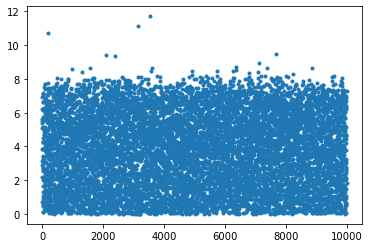

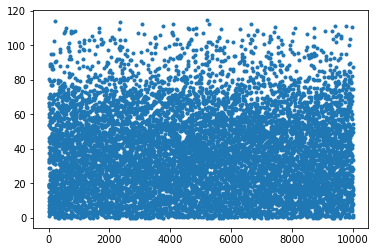

In [14]:
plt.figure()
plt.scatter(np.arange(0,10000),abs_perc_error_Y[:,0].to('cpu'), marker='.')
plt.show()

plt.figure()
plt.scatter(np.arange(0,10000),abs_perc_error_Y[:,1].to('cpu'), marker='.')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# %matplotlib inline
# plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(predictZ[:,0].to('cpu').numpy(), predictZ[:,1].to('cpu').numpy(), predictZ[:,2].to('cpu').numpy())
# plt.show()

In [ ]:
%matplotlib widget
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(predictZ[:,0].to('cpu').numpy(), predictZ[:,1].to('cpu').numpy(),Y[:,3].to('cpu').numpy())
plt.show()

In [ ]:
# Prepare Data
data = pd.read_csv('Data Workspace\FM_TV_Data.csv')
num_freq = 10

X_names = freq_name(num_freq,1,0)
Y_names = ['E', 'nu', 'rho', 'a', 'b', 't']

train_split = int(0.8*len(data))
valid_split = len(data)- train_split

scaled_data = data[X_names+Y_names].copy()

# scaled_data['psi'] = np.log(scaled_data['psi'])
# scaled_data['E'] = scaled_data['E']/1e11
# scaled_data['rho'] = scaled_data['rho']/10000
# scaled_data['t'] = scaled_data['t']*100
scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])

scaled_data = AE_data(scaled_data, X_names, Y_names)
# test_loader = to.utils.data.DataLoader(scaled_data, batch_size=1, shuffle=False)

In [ ]:
num = 777
pic = np.ones((10,10))
props = scaled_data.__getitem__(num)[1].to('cpu').numpy()
freqs = scaled_data.__getitem__(num)[0].to('cpu').numpy()

count = 0
for i in range(10):
    for j in range(i):
        pic[i,j] = freqs[i]/freqs[j]
        pic[j,i] = freqs[i]/freqs[j]

for i in range(6):
    print(Y_names[i], ' = ', props[i])
plt.figure()
plt.imshow(pic, vmin=1)
plt.colorbar()
plt.show()